Reference - https://github.com/faustomorales/vit-keras

In [1]:
!pip install -qq -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


## Setup

In [2]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [3]:
import os
import zipfile
import PIL
import PIL.Image

In [4]:
import pathlib

#importing the dataset enhanced by data augmentation aug_zip

dataset_url = "file:///content/aug_zip.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

233675925/233675925 [==============================] - 1s 0us/step


In [5]:
archive

'/root/.keras/datasets/aug_zip.zip'

In [6]:
os.path.getsize(archive)

233675925

In [7]:
with zipfile.ZipFile(archive,"r") as zip_ref:
    zip_ref.extractall("targetdir")

In [12]:
data_dir = pathlib.Path('/content/targetdir/aug_zip/')

In [13]:
data_dir

PosixPath('/content/targetdir/aug_zip')

In [14]:
os.path.getsize(data_dir)

4096

In [15]:
for item in data_dir.glob("*"):
  print(item.name)

glass
leather
cardboard
wood
metal
fabric
food
paper
plastic
stone


In [16]:
image_count = len(list(data_dir.glob('fabric/*.jpg')))
print(image_count)

396


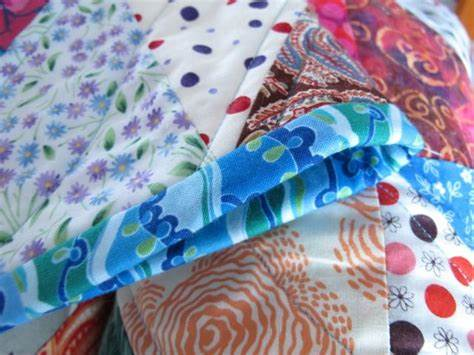

In [17]:
fabric = list(data_dir.glob('fabric/*'))
PIL.Image.open(str(fabric[0]))

In [18]:
batch_size = 32
img_height = 224
img_width = 224

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3974 files belonging to 10 classes.
Using 3180 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3974 files belonging to 10 classes.
Using 794 files for validation.


In [21]:
x_train = []
y_train = []

for images, labels in train_ds:
    x_train.extend(images.numpy())
    y_train.extend(labels.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train)

[[[[182.84822   131.84822    87.61607  ]
   [188.        135.84822    88.45536  ]
   [183.7768    130.61607    77.74921  ]
   ...
   [177.9505    129.9505     81.9505   ]
   [174.76785   126.76786    78.76786  ]
   [174.76785   126.76786    78.76786  ]]

  [[183.23215   132.23215    88.       ]
   [186.87126   134.84822    87.069115 ]
   [184.94077   131.71188    79.75566  ]
   ...
   [174.30357   126.30357    78.30357  ]
   [174.84822   126.84821    78.84821  ]
   [174.84822   126.84821    78.84821  ]]

  [[181.33443   133.49513    86.12093  ]
   [184.60387   134.48868    85.78005  ]
   [186.99355   133.75247    83.67211  ]
   ...
   [173.23462   125.23462    77.23462  ]
   [177.        129.         81.       ]
   [177.        129.         81.       ]]

  ...

  [[176.75894   125.75894    78.75894  ]
   [177.68752   126.68751    79.68751  ]
   [179.84575   128.84575    81.84575  ]
   ...
   [120.91965    76.08035    45.       ]
   [116.70861    73.70861    41.708607 ]
   [120.7866    

In [22]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'fabric', 'food', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'wood']


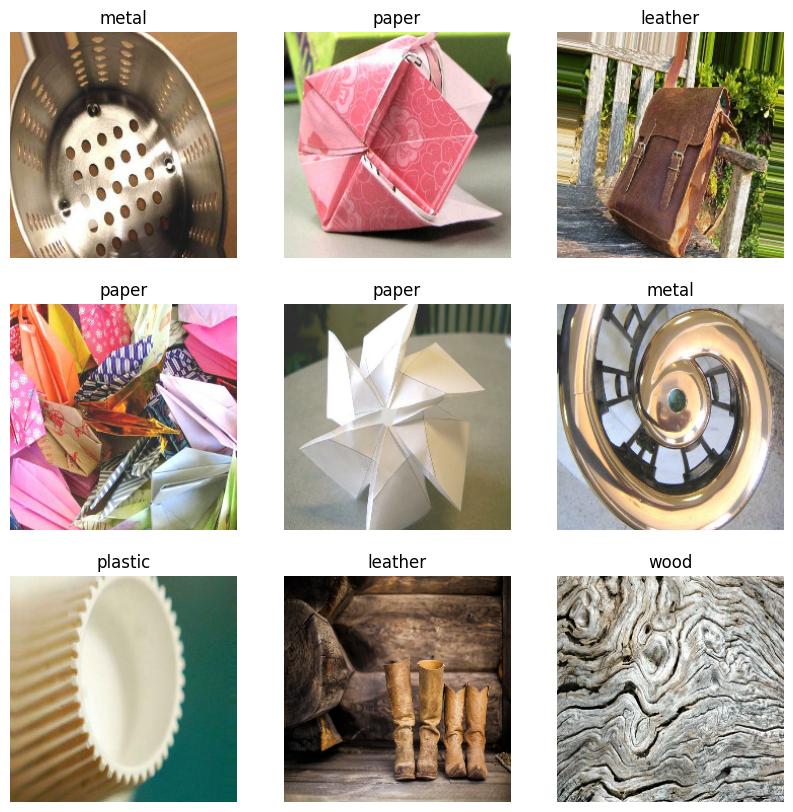

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i].astype("uint8"))
  plt.title(class_names[y_train[i]])
  plt.axis("off")

plt.show()

In [24]:
x_test = []
y_test = []

for images, labels in val_ds:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)


In [25]:
!pip install vit-keras

In [26]:
from vit_keras import vit, utils

img_size = 224
basemodel = vit.vit_b16(
    image_size= (224, 224),
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes = 10
)

347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [27]:
x_train =vit.preprocess_inputs(x_train).reshape(-1,img_size, img_size, 3)
x_train=x_train.astype(np.uint8)

In [28]:
x_test =vit.preprocess_inputs(x_test).reshape(-1,img_size, img_size, 3)
x_test = x_test.astype(np.uint8)

In [29]:
def test_saving():
    inp = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    base = basemodel
    x = base(inp)
    x = tf.keras.layers.Dense(120, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs=inp, outputs=x, name="VIT16" )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer = optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [30]:
model_vit = test_saving()

In [31]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Epoch 1/20
100/100 - 110s - loss: 2.1277 - accuracy: 0.2434 - val_loss: 1.9952 - val_accuracy: 0.2645 - 110s/epoch - 1s/step
Epoch 2/20
100/100 - 47s - loss: 1.8603 - accuracy: 0.3396 - val_loss: 1.9106 - val_accuracy: 0.3010 - 47s/epoch - 470ms/step
Epoch 3/20
100/100 - 47s - loss: 1.6173 - accuracy: 0.4308 - val_loss: 1.9149 - val_accuracy: 0.3325 - 47s/epoch - 472ms/step
Epoch 4/20
100/100 - 47s - loss: 1.2523 - accuracy: 0.5742 - val_loss: 1.9208 - val_accuracy: 0.3564 - 47s/epoch - 471ms/step
Epoch 5/20
100/100 - 47s - loss: 0.9019 - accuracy: 0.7123 - val_loss: 2.0088 - val_accuracy: 0.3552 - 47s/epoch - 469ms/step
Epoch 6/20
100/100 - 47s - loss: 0.5895 - accuracy: 0.8245 - val_loss: 2.2263 - val_accuracy: 0.3539 - 47s/epoch - 470ms/step
Epoch 7/20
100/100 - 47s - loss: 0.3812 - accuracy: 0.8849 - val_loss: 2.3741 - val_accuracy: 0.3640 - 47s/epoch - 471ms/step
Epoch 8/20
100/100 - 47s - loss: 0.3169 - accuracy: 0.9028 - val_loss: 2.3541 - val_accuracy: 0.4018 - 47s/epoch - 470m

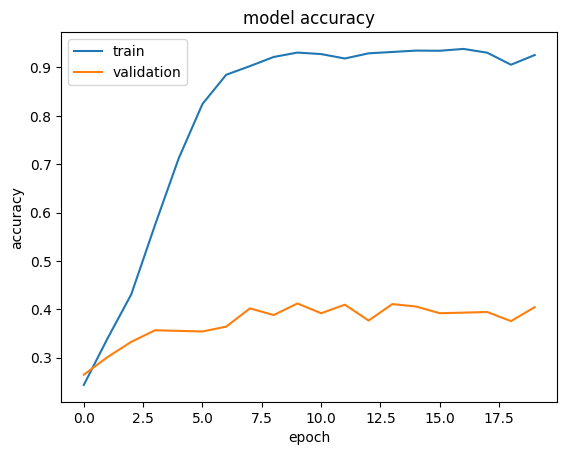

In [32]:
epochs = 20
hist = model_vit.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), verbose=2)
plot_hist(hist)

In [33]:
_, acc =model_vit.evaluate(x_test,y_test)

25/25 [==============================] - 4s 157ms/step - loss: 3.0026 - accuracy: 0.4043


In [34]:
print(acc)

0.4042821228504181
